In [1]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import kornia.augmentation as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [3]:
BANDS = 100
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_BANDS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class HyperspectralDataset(Dataset):
    def __init__(self, df, base_path, patch_size=64, augment=False, num_bands=100):
        self.df = df
        self.base_path = base_path
        self.patch_size = patch_size
        self.augment = augment
        self.num_bands = num_bands
        self.transform = nn.Sequential(
            K.RandomHorizontalFlip(p=0.3),     
            K.RandomVerticalFlip(p=0.3),
            K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.5),
            K.RandomCrop((patch_size, patch_size), padding=4, p=0.5)
        )
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.base_path}/{row['id']}"

        try:
            img = np.load(img_path)

            if len(img.shape) == 2:
                img = np.repeat(img[:, :, np.newaxis], self.num_bands, axis=2)
            elif len(img.shape) == 3:
                if img.shape[2] > self.num_bands:
                    img = img[:, :, :self.num_bands]
                elif img.shape[2] < self.num_bands:
                    pad_width = ((0, 0), (0, 0), (0, self.num_bands - img.shape[2]))
                    img = np.pad(img, pad_width, mode='constant')

            img = img.astype(np.float32) / 65535.0  # Normalize image

            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to [C, H, W]

            if self.augment:
                img = self.transform(img.unsqueeze(0)).squeeze(0)

            if img.shape[1] != self.patch_size or img.shape[2] != self.patch_size:
                img = F.interpolate(img.unsqueeze(0), size=(self.patch_size, self.patch_size), mode='bilinear').squeeze(0)

            label = torch.tensor(row['label'], dtype=torch.long)  

            if label > 0:
                label = label - 1

            return img, label

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            dummy_img = torch.zeros(self.num_bands, self.patch_size, self.patch_size)
            dummy_label = torch.tensor(0, dtype=torch.long)  
            return dummy_img, dummy_label



class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(concat))
        return x * attention


class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return out.view(b, c, 1, 1)


class HyperspectralCNN(nn.Module):
    def __init__(self, in_channels=NUM_BANDS, num_classes=100):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca2 = ChannelAttention(128)
        self.sa2 = SpatialAttention()
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, num_classes) 
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x
        
        x = self.conv2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x
        
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


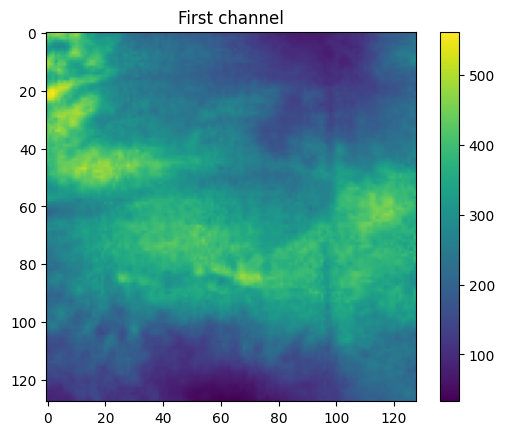

In [4]:
sample = np.load('/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample1024.npy')  # (128, 128, 125)
plt.imshow(sample[:, :, 0])
plt.title('First channel')
plt.colorbar()
plt.show()

In [5]:
def evaluate_model(model, loader, criterion, device = DEVICE):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item() * inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue
                
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if torch.isnan(outputs).any():
                continue
                
            loss = criterion(outputs.squeeze(), labels) 
            
            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
                valid_samples += inputs.size(0)
        
        if valid_samples > 0:
            train_loss /= valid_samples
            val_loss, val_preds, val_labels = evaluate_model(model, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            if len(val_preds.shape) == 2: 
                val_preds = np.argmax(val_preds, axis=1)
            
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"Sample predictions: {val_preds[:5]}, True labels: {val_labels[:5]}")
            
            
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), 'Spectrum_CNN.pth')
        else:
            print(f"Epoch {epoch+1}: No valid training samples")
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model


Epoch 1/50: 100%|██████████| 55/55 [00:34<00:00,  1.60it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 1: Train Loss: 4.6101, Val Loss: 4.6117
Sample predictions: [18 18 18 18 18], True labels: [78 66 91 91 11]


Epoch 2/50: 100%|██████████| 55/55 [00:19<00:00,  2.76it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 2: Train Loss: 4.5980, Val Loss: 4.6142
Sample predictions: [20 20 20 20 20], True labels: [78 66 91 91 11]


Epoch 3/50: 100%|██████████| 55/55 [00:19<00:00,  2.80it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 3: Train Loss: 4.5876, Val Loss: 4.6267
Sample predictions: [ 4 82 82  4  4], True labels: [78 66 91 91 11]


Epoch 4/50: 100%|██████████| 55/55 [00:19<00:00,  2.82it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 4: Train Loss: 4.5780, Val Loss: 4.6271
Sample predictions: [4 4 4 4 4], True labels: [78 66 91 91 11]


Epoch 5/50: 100%|██████████| 55/55 [00:19<00:00,  2.83it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 5: Train Loss: 4.5656, Val Loss: 4.6421
Sample predictions: [4 4 4 4 4], True labels: [78 66 91 91 11]


Epoch 6/50: 100%|██████████| 55/55 [00:19<00:00,  2.78it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 6: Train Loss: 4.5620, Val Loss: 4.6364
Sample predictions: [4 4 4 4 4], True labels: [78 66 91 91 11]


Epoch 7/50: 100%|██████████| 55/55 [00:20<00:00,  2.75it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 7: Train Loss: 4.5534, Val Loss: 4.6366
Sample predictions: [4 4 4 4 4], True labels: [78 66 91 91 11]


Epoch 8/50: 100%|██████████| 55/55 [00:19<00:00,  2.75it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 8: Train Loss: 4.5433, Val Loss: 4.6627
Sample predictions: [ 4  4 21  4  4], True labels: [78 66 91 91 11]


Epoch 9/50: 100%|██████████| 55/55 [00:19<00:00,  2.85it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 9: Train Loss: 4.5381, Val Loss: 4.6670
Sample predictions: [11  4 53 11 11], True labels: [78 66 91 91 11]


Epoch 10/50: 100%|██████████| 55/55 [00:19<00:00,  2.79it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 10: Train Loss: 4.5301, Val Loss: 4.6793
Sample predictions: [62  4  4 62 62], True labels: [78 66 91 91 11]


Epoch 11/50: 100%|██████████| 55/55 [00:18<00:00,  2.90it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 11: Train Loss: 4.5291, Val Loss: 4.6800
Sample predictions: [71  4 69 71 79], True labels: [78 66 91 91 11]


Epoch 12/50: 100%|██████████| 55/55 [00:19<00:00,  2.81it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 12: Train Loss: 4.5283, Val Loss: 4.6993
Sample predictions: [10  4  4 10 10], True labels: [78 66 91 91 11]


Epoch 13/50: 100%|██████████| 55/55 [00:19<00:00,  2.81it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 13: Train Loss: 4.5200, Val Loss: 4.7094
Sample predictions: [65  4  4 65 65], True labels: [78 66 91 91 11]


Epoch 14/50: 100%|██████████| 55/55 [00:19<00:00,  2.79it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 14: Train Loss: 4.5128, Val Loss: 4.7042
Sample predictions: [13  4  4 13 13], True labels: [78 66 91 91 11]


Epoch 15/50: 100%|██████████| 55/55 [00:19<00:00,  2.81it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 15: Train Loss: 4.5138, Val Loss: 4.7090
Sample predictions: [13 82  4 11 65], True labels: [78 66 91 91 11]


Epoch 16/50: 100%|██████████| 55/55 [00:19<00:00,  2.81it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 16: Train Loss: 4.5117, Val Loss: 4.7228
Sample predictions: [11 82  4 11 11], True labels: [78 66 91 91 11]


Epoch 17/50: 100%|██████████| 55/55 [00:19<00:00,  2.83it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 17: Train Loss: 4.4982, Val Loss: 4.7339
Sample predictions: [11 82  4 11 11], True labels: [78 66 91 91 11]


Epoch 18/50: 100%|██████████| 55/55 [00:19<00:00,  2.81it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 18: Train Loss: 4.5104, Val Loss: 4.7129
Sample predictions: [65 82  4 65 65], True labels: [78 66 91 91 11]


Epoch 19/50: 100%|██████████| 55/55 [00:18<00:00,  2.93it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 19: Train Loss: 4.5067, Val Loss: 4.7054
Sample predictions: [65 82 82 65 65], True labels: [78 66 91 91 11]


Epoch 20/50: 100%|██████████| 55/55 [00:19<00:00,  2.81it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 20: Train Loss: 4.4985, Val Loss: 4.6916
Sample predictions: [65 82 53 65 65], True labels: [78 66 91 91 11]


Epoch 21/50: 100%|██████████| 55/55 [00:19<00:00,  2.85it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 21: Train Loss: 4.5057, Val Loss: 4.7150
Sample predictions: [13 82  4 65 13], True labels: [78 66 91 91 11]


Epoch 22/50: 100%|██████████| 55/55 [00:19<00:00,  2.86it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 22: Train Loss: 4.4969, Val Loss: 4.7213
Sample predictions: [65 82  4 65 65], True labels: [78 66 91 91 11]


Epoch 23/50: 100%|██████████| 55/55 [00:19<00:00,  2.83it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 23: Train Loss: 4.4953, Val Loss: 4.7032
Sample predictions: [62 79 82 20 62], True labels: [78 66 91 91 11]


Epoch 24/50: 100%|██████████| 55/55 [00:19<00:00,  2.84it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 24: Train Loss: 4.4935, Val Loss: 4.7324
Sample predictions: [65  6  6 65 65], True labels: [78 66 91 91 11]


Epoch 25/50: 100%|██████████| 55/55 [00:18<00:00,  2.91it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 25: Train Loss: 4.4936, Val Loss: 4.7008
Sample predictions: [65 82  6 65 65], True labels: [78 66 91 91 11]


Epoch 26/50: 100%|██████████| 55/55 [00:19<00:00,  2.85it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 26: Train Loss: 4.4870, Val Loss: 4.7033
Sample predictions: [65 62  6 65 65], True labels: [78 66 91 91 11]


Epoch 27/50: 100%|██████████| 55/55 [00:19<00:00,  2.88it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 27: Train Loss: 4.4812, Val Loss: 4.7567
Sample predictions: [12 79 18 65 65], True labels: [78 66 91 91 11]


Epoch 28/50: 100%|██████████| 55/55 [00:19<00:00,  2.82it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 28: Train Loss: 4.4798, Val Loss: 4.6994
Sample predictions: [65 65 79 65 65], True labels: [78 66 91 91 11]


Epoch 29/50: 100%|██████████| 55/55 [00:19<00:00,  2.82it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 29: Train Loss: 4.4739, Val Loss: 4.7589
Sample predictions: [12  6  6 65 65], True labels: [78 66 91 91 11]


Epoch 30/50: 100%|██████████| 55/55 [00:19<00:00,  2.82it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 30: Train Loss: 4.4673, Val Loss: 4.7277
Sample predictions: [65 18 18 65 65], True labels: [78 66 91 91 11]


Epoch 31/50: 100%|██████████| 55/55 [00:19<00:00,  2.86it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 31: Train Loss: 4.4729, Val Loss: 4.8498
Sample predictions: [11 18 18 11 11], True labels: [78 66 91 91 11]


Epoch 32/50: 100%|██████████| 55/55 [00:19<00:00,  2.77it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 32: Train Loss: 4.4788, Val Loss: 4.7929
Sample predictions: [13 18 18 13 12], True labels: [78 66 91 91 11]


Epoch 33/50: 100%|██████████| 55/55 [00:19<00:00,  2.83it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 33: Train Loss: 4.4587, Val Loss: 4.7681
Sample predictions: [13 18 18 13 13], True labels: [78 66 91 91 11]


Epoch 34/50: 100%|██████████| 55/55 [00:19<00:00,  2.79it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 34: Train Loss: 4.4628, Val Loss: 4.8592
Sample predictions: [13  6  6 13 65], True labels: [78 66 91 91 11]


Epoch 35/50: 100%|██████████| 55/55 [00:19<00:00,  2.85it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 35: Train Loss: 4.4571, Val Loss: 4.7360
Sample predictions: [12  6  6 65 12], True labels: [78 66 91 91 11]


Epoch 36/50: 100%|██████████| 55/55 [00:20<00:00,  2.72it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 36: Train Loss: 4.4619, Val Loss: 4.7554
Sample predictions: [65 18 18 65 65], True labels: [78 66 91 91 11]


Epoch 37/50: 100%|██████████| 55/55 [00:19<00:00,  2.85it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 37: Train Loss: 4.4411, Val Loss: 4.8028
Sample predictions: [13  6  6 20 13], True labels: [78 66 91 91 11]


Epoch 38/50: 100%|██████████| 55/55 [00:19<00:00,  2.80it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 38: Train Loss: 4.4340, Val Loss: 4.7940
Sample predictions: [13  6  6 13 13], True labels: [78 66 91 91 11]


Epoch 39/50: 100%|██████████| 55/55 [00:19<00:00,  2.87it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 39: Train Loss: 4.4467, Val Loss: 4.7910
Sample predictions: [13 18  6 13 13], True labels: [78 66 91 91 11]


Epoch 40/50: 100%|██████████| 55/55 [00:19<00:00,  2.80it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 40: Train Loss: 4.4450, Val Loss: 4.7783
Sample predictions: [13 18 18 13 13], True labels: [78 66 91 91 11]


Epoch 41/50: 100%|██████████| 55/55 [00:19<00:00,  2.86it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 41: Train Loss: 4.4300, Val Loss: 4.7806
Sample predictions: [13 18 18 15 65], True labels: [78 66 91 91 11]


Epoch 42/50: 100%|██████████| 55/55 [00:19<00:00,  2.77it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 42: Train Loss: 4.4343, Val Loss: 4.7781
Sample predictions: [65 18  6 65 65], True labels: [78 66 91 91 11]


Epoch 43/50: 100%|██████████| 55/55 [00:19<00:00,  2.88it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 43: Train Loss: 4.4292, Val Loss: 4.7535
Sample predictions: [65 14  6 62 65], True labels: [78 66 91 91 11]


Epoch 44/50: 100%|██████████| 55/55 [00:19<00:00,  2.88it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 44: Train Loss: 4.4261, Val Loss: 4.7608
Sample predictions: [13 18 18 62 13], True labels: [78 66 91 91 11]


Epoch 45/50: 100%|██████████| 55/55 [00:19<00:00,  2.84it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 45: Train Loss: 4.4147, Val Loss: 4.7872
Sample predictions: [12 14  6 62 12], True labels: [78 66 91 91 11]


Epoch 46/50: 100%|██████████| 55/55 [00:19<00:00,  2.78it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 46: Train Loss: 4.4144, Val Loss: 4.7762
Sample predictions: [65 18 18 60 65], True labels: [78 66 91 91 11]


Epoch 47/50: 100%|██████████| 55/55 [00:19<00:00,  2.80it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 47: Train Loss: 4.4227, Val Loss: 4.8088
Sample predictions: [65 18  6 60 65], True labels: [78 66 91 91 11]


Epoch 48/50: 100%|██████████| 55/55 [00:19<00:00,  2.79it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 48: Train Loss: 4.3971, Val Loss: 4.8194
Sample predictions: [13  6  6 62 13], True labels: [78 66 91 91 11]


Epoch 49/50: 100%|██████████| 55/55 [00:18<00:00,  2.93it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 49: Train Loss: 4.4047, Val Loss: 4.8892
Sample predictions: [13 18  6 99 10], True labels: [78 66 91 91 11]


Epoch 50/50: 100%|██████████| 55/55 [00:19<00:00,  2.86it/s]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 50: Train Loss: 4.4069, Val Loss: 4.8545
Sample predictions: [13 18  6 13 99], True labels: [78 66 91 91 11]


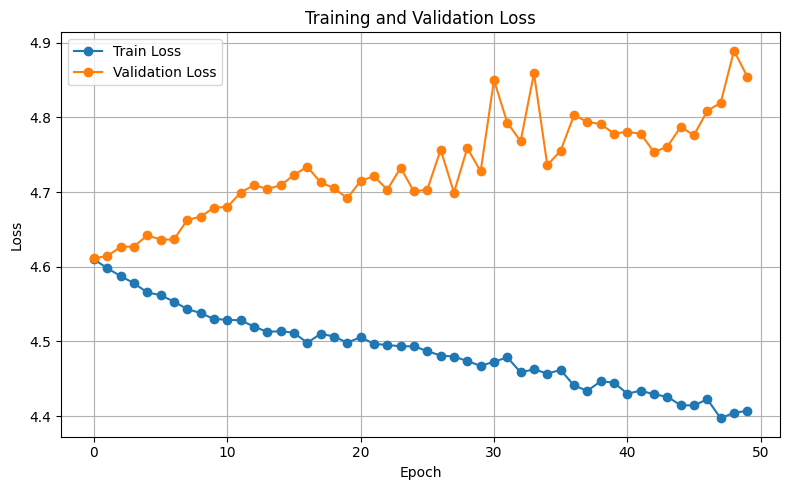

/tmp/ipykernel_33/2502131370.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Spectrum_CNN.pth'))


In [6]:
def main():
    train_df = pd.read_csv('/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/train.csv')
    base_path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot'
    
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
    
    train_dataset = HyperspectralDataset(train_df, base_path, augment=True)
    val_dataset = HyperspectralDataset(val_df, base_path, augment=False)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    model = HyperspectralCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    model = train_model(model, train_loader, val_loader, EPOCHS, criterion, optimizer)
    
    model.load_state_dict(torch.load('Spectrum_CNN.pth'))
    
    return model

if __name__ == '__main__':
    model = main()

In [7]:
model = HyperspectralCNN(in_channels=100).to(DEVICE)
model.load_state_dict(torch.load('Spectrum_CNN.pth'))
model.eval()
print("Model weights:", list(model.parameters())[0][0, 0, :5])
test_input = torch.randn(1, 100, 64, 64).to(DEVICE)

class TestHyperspectralDataset(Dataset):
    def __init__(self, test_csv, base_path, patch_size=64, num_bands=100):
        self.df = pd.read_csv(test_csv)
        self.base_path = base_path
        self.patch_size = patch_size
        self.num_bands = num_bands
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_path, row['id'])
        
        try:
            img = np.load(img_path)
            
            if len(img.shape) == 2:
                img = np.repeat(img[:, :, np.newaxis], self.num_bands, axis=2)
            elif len(img.shape) == 3:
                if img.shape[2] > self.num_bands:
                    img = img[:, :, :self.num_bands] 
                elif img.shape[2] < self.num_bands:
                    pad_width = ((0, 0), (0, 0), (0, self.num_bands - img.shape[2]))
                    img = np.pad(img, pad_width, mode='constant')
            
            normalized_img = np.zeros_like(img)
            for band in range(img.shape[2]):
                band_data = img[:, :, band]
                if np.max(band_data) > 0:  
                    normalized_img[:, :, band] = (band_data - np.min(band_data)) / (np.max(band_data) - np.min(band_data))
            
            img_tensor = torch.tensor(normalized_img, dtype=torch.float32).permute(2, 0, 1)
            
            if img_tensor.shape[1] != self.patch_size or img_tensor.shape[2] != self.patch_size:
                img_tensor = F.interpolate(img_tensor.unsqueeze(0), 
                                         size=(self.patch_size, self.patch_size),
                                         mode='bilinear').squeeze(0)
            
            return img_tensor, row['id']
        
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            dummy_img = torch.zeros(self.num_bands, self.patch_size, self.patch_size)
            return dummy_img, row['id']


test_csv_path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/test.csv'
base_path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot'

test_dataset = TestHyperspectralDataset(test_csv_path, base_path, num_bands=100)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

predictions = []
ids = []

with torch.no_grad():
    for inputs, img_ids in test_loader:
        inputs = inputs.to(DEVICE)
        
        if torch.isnan(inputs).any():
            print(f"Skipping batch with NaN values")
            predictions.extend([50] * len(img_ids))  
            ids.extend(img_ids)
            continue
            
        outputs = model(inputs)
        preds = outputs.squeeze().cpu().numpy()
        print(preds)
        preds = np.clip(preds, 1, 100).round().astype(int)
        print(preds)
        if isinstance(preds, np.ndarray) and preds.ndim > 1:
            preds = np.max(preds, axis=1)  

        if len(preds) != len(img_ids):
            preds = preds[:len(img_ids)]  

        predictions.extend(preds.tolist())  
        ids.extend(img_ids)



submission_df = pd.DataFrame({'ID': ids, 'TARGET': predictions})
submission_df.to_csv('submission.csv', index=False)
print("Submission created successfully")
print("\nSubmission preview:")
print(submission_df.head())

/tmp/ipykernel_33/4053426474.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Spectrum_CNN.pth'))


Model weights: tensor([[ 0.0140,  0.0352,  0.0328],
        [-0.0084, -0.0156,  0.0162],
        [ 0.0080, -0.0029, -0.0078]], device='cuda:0',
       grad_fn=<SliceBackward0>)
[[ 0.00181402 -0.09068955 -0.07520781 ...  0.0892567  -0.0506807
  -0.05733831]
 [ 0.00152    -0.09261747 -0.07301347 ...  0.08809324 -0.05021447
  -0.05375932]
 [ 0.00176373 -0.09159441 -0.07412557 ...  0.08870647 -0.05052571
  -0.05558855]
 ...
 [ 0.00182521 -0.09032901 -0.07562685 ...  0.08945962 -0.05073715
  -0.05799008]
 [ 0.00165744 -0.09220007 -0.07344256 ...  0.08834215 -0.05037123
  -0.05445693]
 [ 0.001852   -0.08955312 -0.07647544 ...  0.0898749  -0.05080068
  -0.05918348]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[ 0.00117943 -0.09354627 -0.07199731 ...  0.08750664 -0.04981746
  -0.0519494 ]
 [ 0.00172598 -0.09144118 -0.07430834 ...  0.08880275 -0.0505265
  -0.05586348]
 [ 0.00184262 -0.08984562 -0.07616233 ...  0.089724